In [12]:
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import time
import numpy as np

from policy_gradients import PolicyGradients, Policy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

env = gym.make('Pendulum-v1')
#env = gym.make('CartPole-v1')

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_states = env.observation_space.shape[0]
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

device: cuda:0


In [13]:
def perform_single_rollout(env, agent, episode_nb, render=False):

    # Modify this function to return a tuple of numpy arrays containing (observations, actions, rewards).
    # (np.array(obs), np.array(acs), np.array(rws))
    # np.array(obs) -> shape: (time_steps, nb_obs)
    # np.array(acs) -> shape: (time_steps, nb_acs) if actions are continuous, (time_steps,) if actions are discrete
    # np.array(rws) -> shape: (time_steps,)

    ob_t = env.reset()
    
    done = False
    episode_reward = 0
    nb_steps = 0
    
    obs, acs, rws = [], [], []

    while not done:

        if render:
            env.render()
            time.sleep(1. / 60)

        action = agent.select_action(ob_t) # cambiar a que solo reciba la accion?

        ob_t1, reward, done, _ = env.step(action)

        ob_t = np.squeeze(ob_t1) # <-- may not be needed depending on gym version
        episode_reward += reward
        
        nb_steps += 1

        obs.append(ob_t)
        acs.append(action)
        rws.append(reward)

        if done:
            
            obs = np.array(obs)
            acs = np.array(acs)
            rws = np.array(rws)
            
            assert obs.shape == (nb_steps, dim_states), 'shape of np.array(obs) is not (time_steps, nb_obs)'
            if continuous_control:
                assert acs.shape == (nb_steps, dim_actions), 'shape of np.array(acs) is not (time_steps, nb_acs)'
            else:
                assert acs.shape == (nb_steps,), 'shape of np.array(acs) is not (time_steps,)'
            assert rws.shape == (nb_steps,), 'shape of np.array(rws) is not (time_steps,)'
            
            return obs, acs, rws
        
        
env = gym.make('Pendulum-v1')
#env = gym.make('CartPole-v1')
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_states = env.observation_space.shape[0]
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

agent = PolicyGradients(dim_states = dim_states, dim_actions = dim_actions, lr = 1e-3, gamma = .99, 
                        continuous_control = continuous_control)

perform_single_rollout(env, agent, 1)

(array([[-5.2559847e-01, -8.5073280e-01, -3.3105612e-02],
        [-5.5307019e-01, -8.3313465e-01, -6.5252948e-01],
        [-5.9781814e-01, -8.0163175e-01, -1.0946327e+00],
        [-6.6646457e-01, -7.4553668e-01, -1.7736003e+00],
        [-7.4989557e-01, -6.6155624e-01, -2.3689535e+00],
        [-8.4033841e-01, -5.4206216e-01, -3.0000598e+00],
        [-9.2093253e-01, -3.8972199e-01, -3.4511888e+00],
        [-9.7903341e-01, -2.0369977e-01, -3.9038849e+00],
        [-9.9999809e-01, -1.9448813e-03, -4.0638113e+00],
        [-9.7840923e-01,  2.0667712e-01, -4.2024484e+00],
        [-9.1723561e-01,  3.9834511e-01, -4.0306883e+00],
        [-8.2349509e-01,  5.6732339e-01, -3.8707993e+00],
        [-7.1184510e-01,  7.0233649e-01, -3.5084529e+00],
        [-6.0011619e-01,  7.9991281e-01, -2.9695084e+00],
        [-4.9307144e-01,  8.6998880e-01, -2.5605938e+00],
        [-3.9916033e-01,  9.1688114e-01, -2.1003163e+00],
        [-3.3618337e-01,  9.4179654e-01, -1.3547883e+00],
        [-3.07

In [14]:
def sample_rollouts(env, agent, training_iter, min_batch_steps):

    sampled_rollouts = []
    total_nb_steps = 0
    episode_nb = 0
    
    while total_nb_steps < min_batch_steps:

        episode_nb += 1
        #render = training_iter%10 == 0 and len(sampled_rollouts) == 0 # Change training_iter%10 to any number you want
        render = False

        # Use perform_single_rollout to get data 
        # Uncomment once perform_single_rollout works.
        # Return sampled_rollouts
        
        """
        sample_rollout = perform_single_rollout(env, agent, episode_nb, render=render)
        total_nb_steps += len(sample_rollout[0])

        sampled_rollouts.append(sample_rollout)
        """
        
        sample_rollout = perform_single_rollout(env, agent, episode_nb, render=render)
        total_nb_steps += len(sample_rollout[0])

        sampled_rollouts.append(sample_rollout)
        
    return sampled_rollouts

In [15]:
_use_reward_to_go = False
_use_baseline = False
_gamma = 0.99

def estimate_returns(rollouts_rew):
    estimated_returns = []
    for rollout_rew in rollouts_rew:
            
        if _use_reward_to_go:
            # only for part 2
            estimated_return = None
        else:
            estimated_return = [rollout_rew[t] * (_gamma ** t) for t in range(len(rollout_rew))]
        
        estimated_returns = np.concatenate([estimated_returns, estimated_return])

    if _use_baseline:
        # only for part 2
        average_return_baseline = None
        # Use the baseline:
        #estimated_returns -= average_return_baseline

    return np.array(estimated_returns, dtype=np.float32)

In [33]:
#env = gym.make('Pendulum-v1')
env = gym.make('CartPole-v1')
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_states = env.observation_space.shape[0]
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

training_iterations = 1000
min_batch_steps = 5000

policy = Policy(dim_states=dim_states, dim_actions=dim_actions, continuous_control=continuous_control).to(device)

agent = PolicyGradients(dim_states = dim_states, dim_actions = dim_actions, lr = 1e-3, gamma = .99, 
                        continuous_control = continuous_control)

optimizer = torch.optim.Adam(params = policy.parameters(), lr = 1e-3)

output = sample_rollouts(env, agent, training_iter=training_iterations, min_batch_steps=min_batch_steps)

sampled_obs = [output[i][0] for i in range(len(output))]
sampled_acs = [output[i][1] for i in range(len(output))]
sampled_rew = [output[i][2] for i in range(len(output))]

rewards = sampled_rew[0]
gamma = 0.99

estimated_returns = estimate_returns(sampled_rew)
estimated_returns.shape

(5045,)

In [45]:
a = torch.tensor([1, 2])
b = torch.tensor([3, 4])

a * b

tensor([3, 8])

In [43]:
from collections import deque

rewards = [1, 1, 1]

estimated_return = deque() # for efficiency
n_steps = len(rewards) # steps of rollout

for t in range(n_steps)[::-1]:
    disc_return_t = estimated_return[0] if len(estimated_return) > 0 else 0
    estimated_return.appendleft(disc_return_t * gamma + rewards[t]) # pi_t = pi_{t+1} + r_t
    
list(estimated_return)

[2.9701, 1.99, 1.0]

In [ ]:
rollout_obs = np.concatenate(sampled_obs)
rollout_acs = np.concatenate(sampled_acs)

rollout_obs = torch.from_numpy(rollout_obs)
rollout_acs = torch.from_numpy(rollout_acs)

if continuous_control:
    mean, std = policy(rollout_obs)
    distr = Normal(mean, std) # 200 mean, 1 std
else:
    probs = policy(rollout_obs) #.cpu()
    distr = Categorical(probs)

log_probs = distr.log_prob(rollout_acs) # return log_prob for each pair mean-action
log_probs = log_probs.squeeze()

loss = log_probs * torch.from_numpy(estimated_returns)

loss = loss.mean()

optimizer.zero_grad()
loss.backward()
optimizer.step()

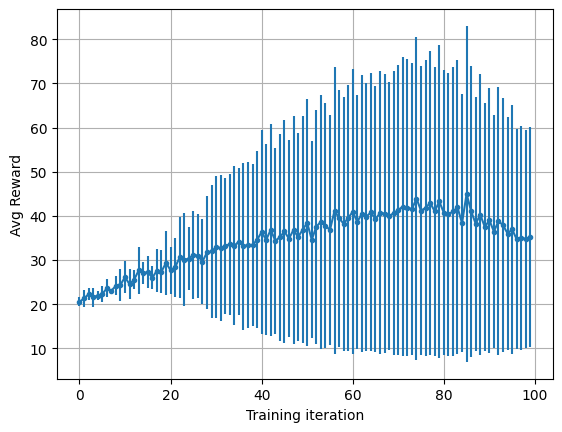

In [26]:
files = os.listdir('metrics')

exp_files = [file for file in files if exp_id in file]

exp_data = pd.DataFrame()
for file in exp_files:
    
    file_data = pd.read_csv(f'metrics/{file}', sep = '\t')
    exp_data = pd.concat((exp_data, file_data), axis = 1)
    
steps = exp_data['steps'].mean(axis = 1)
avg_reward = exp_data['avg_reward'].mean(axis = 1)
std_reward = exp_data['avg_reward'].std(axis = 1)

plt.errorbar(steps, avg_reward, yerr = std_reward, marker = '.', color = 'C0')
plt.xlabel('Training iteration')
plt.ylabel('Avg Reward')
plt.grid('on')
plt.show()

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_performance_metrics(tr_steps_vec, avg_reward_vec, std_reward_vec, exp_id):
    plt.errorbar(tr_steps_vec, avg_reward_vec, yerr = std_reward_vec, marker = '.', color = 'C0')
    plt.xlabel('Training Iteration')
    plt.ylabel('Avg Reward')
    plt.grid('on')
    plt.savefig(f'figures/agg_experiments/{exp_id}.pdf')
    plt.close()
    
def plot_experiment(exp_id):

    files = os.listdir('metrics')

    exp_files = [file for file in files if exp_id in file]

    exp_data = pd.DataFrame()

    for file in exp_files:
        
        file_data = pd.read_csv(f'metrics/{file}', sep = '\t')
        exp_data = pd.concat((exp_data, file_data), axis = 1)

    steps = exp_data['steps'].mean(axis = 1)
    avg_reward = exp_data['avg_reward'].mean(axis = 1)
    std_reward = exp_data['avg_reward'].std(axis = 1)

    plot_performance_metrics(steps, avg_reward, std_reward, exp_id)

if __name__ == '__main__':

    # experiment ids
    ids = ['CartPole_exp_11', 'CartPole_exp_21', 'CartPole_exp_31', 'CartPole_exp_41', 
           'CartPole_exp_12', 'CartPole_exp_22', 'CartPole_exp_32', 'CartPole_exp_42',
           'Pendulum_exp_12', 'Pendulum_exp_22', 'Pendulum_exp_32', 'Pendulum_exp_42'
           ]

    # plot for each experiment
    for exp_id in ids:
        print(exp_id)
        plot_experiment(exp_id)

CartPole_exp_11
CartPole_exp_21
CartPole_exp_31
CartPole_exp_41
CartPole_exp_12
CartPole_exp_22
CartPole_exp_32
CartPole_exp_42
Pendulum_exp_12
Pendulum_exp_22


ValueError: No axis named 1 for object type Series